In [1]:
# !pip install opencv-python
# !pip install scikit-image

Загрузим необходимые библиотеки.

In [2]:
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import skimage

skimage.__version__

'0.15.0'

In [4]:
import cv2

cv2.__version__

'4.1.1'

Некоторые дополнительные функции.

In [5]:
def plot_image(img, zoom=1.5):
    assert(2 <= len(img.shape) <= 3)
    
    is_gray = len(img.shape) == 2
    if not is_gray:
        img = img[:,:,::-1]
    n_len = 6.5
    
    n, m = img.shape[:2]
    frac = n / float(m)
    n, m = zoom * frac * n_len, zoom * n_len
    
    fig = plt.figure(figsize=(n, m))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray' if is_gray else None)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')
    plt.show()

In [6]:
def plot_hists(img, x_lim=(0, 255)):
    assert(2 <= len(img.shape) <= 3)
    
    if len(img.shape) == 3:
        f, ax = plt.subplots(3, 1, sharex=True, figsize=(6, 6))
        
        for i, ch in enumerate(['Blue', 'Green', 'Red']):
            values = img[:,:,i].reshape(-1)
            if x_lim != (0, 255):
                mask = np.logical_and(x_lim[0] <= values, values <= x_lim[1])
                values = values[mask]
            
            ax[i].set_xlim(x_lim)
            ax[i].hist(values, bins=x_lim[1]-x_lim[0]+1, color=ch.lower())
            ax[i].set_title(ch)
    elif len(img.shape) == 2:
        f, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 2))
        
        values = img.reshape(-1)
        if x_lim != (0, 255):
            mask = np.logical_and(x_lim[0] <= values, values <= x_lim[1])
            values = values[mask]
        
        ax.set_xlim(x_lim)
        ax.hist(values, bins=x_lim[1]-x_lim[0]+1)
        ax.set_title('Gray')

    plt.show()

`skimage` загружает изображение в виде специального класса `Image`. По факту, `Image` - подкласс `np.ndarray`.

In [7]:
img = skimage.io.imread('data/IMG_1.jpg')
type(img)

imageio.core.util.Array

In [8]:
isinstance(img, np.ndarray)

True

Нарисовать изображение можно следующим образом.

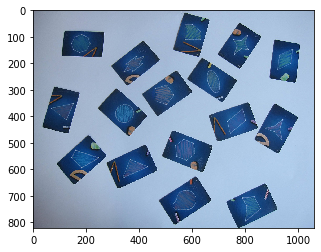

In [9]:
plt.imshow(img)

Зачастую для решения некоторых задач с изображениями работают не с цветным изображением, а с "серым" изображением. Формула для перевода цветного изображения выглядит следующим образом:

$$Y = 0.299R + 0.587G + 0.114B$$

Полученная велична имеет смысл относительной яркости цвета (relative luminance/luma).

Перевести изображение в оттенки серого можно следующим образом c помощью библиотеки `skimage`. 

min: 0.004807; max: 0.945600


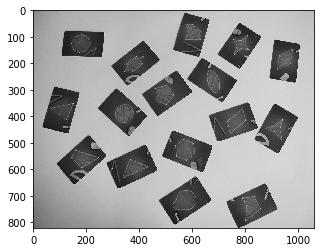

In [10]:
img_grey = skimage.color.rgb2grey(img)
print("min: {:.6f}; max: {:.6f}".format(img_grey.min(), img_grey.max()))
plt.imshow(img_grey, cmap='gray')

Имеется возможность сразу загрузить изображение в оттенкахх серого.

min: 0.004807; max: 0.945600


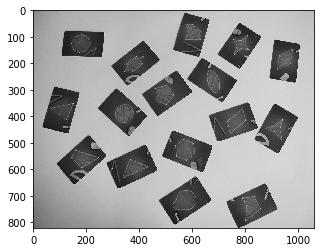

In [11]:
img_grey = skimage.io.imread('data/IMG_1.jpg', as_gray=True)
print("min: {:.6f}; max: {:.6f}".format(img_grey.min(), img_grey.max()))
plt.imshow(img_grey, cmap='gray')

`opencv` же загружает изображение просто как `np.ndarray`. Но каналы идут в обратном порядке.

<class 'numpy.ndarray'>


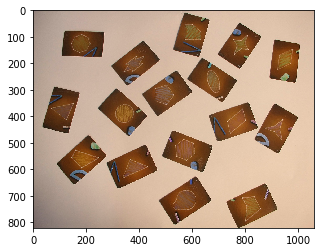

In [12]:
img = cv2.imread('data/IMG_1.jpg', 1)
print(type(img))
plt.imshow(img)

In [13]:
img_color = img

`opencv` также позволяет загружать изображение сразу в оттенках серого.

min: 0; max: 239


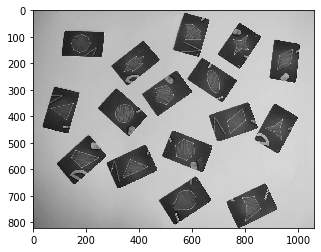

In [14]:
img_grey = cv2.imread('data/IMG_1.jpg', 0)
print("min: {}; max: {}".format(img_grey.min(), img_grey.max()))
plt.imshow(img_grey, cmap='gray')

<span style="color:red;font-weight:bold">Внмание:</span> обратите внмание, что значения пикселя для библиотеки `skimage` изменяется в диапазоне `[0.0;1.0)`, а для `opencv` - `[0;255]`.

## Задача 1. Поиск карточек

Увеличим изображение поближе.

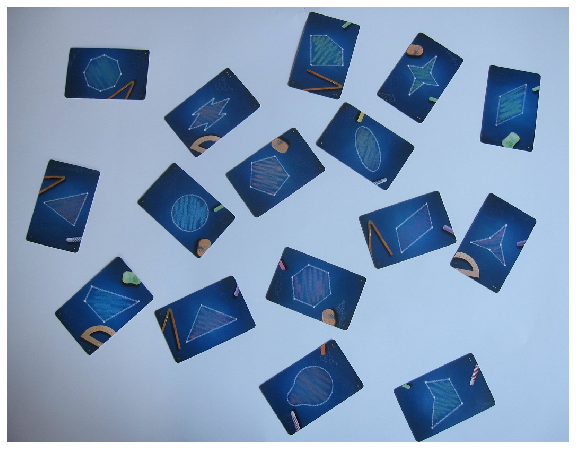

In [15]:
plot_image(img, zoom=2.0)

На нём изображены карточки из игрового набора для детей дошкольного возраста. Попробуем решить следующую задачу: найти области соответвующие карточкам.

Для отделения карточек от исходного изображения нужно бинаризовать изображение.

Бинаризация — перевод изображения в черно-белое. Выделяют несколько типов бинаризации:
* глобальная (один порог для всех пикселей);
* локальная (порог зависит от положения пикселя);
* адаптивная (порог зависит от положения и от яркости пикселя).

Построим гистограмму.

<span style="color:blue;font-weight:bold">Вопрос:</span> какой вариант бинаризации подойдет в этом случае?

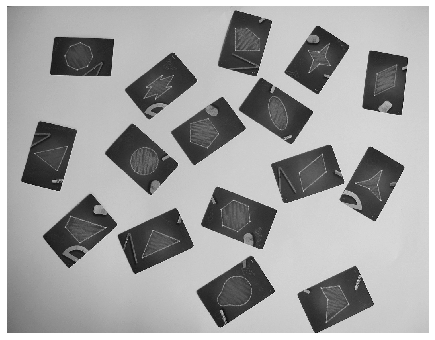

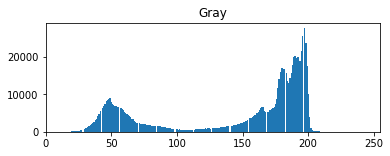

In [16]:
plot_image(img_grey)
plot_hists(img_grey)

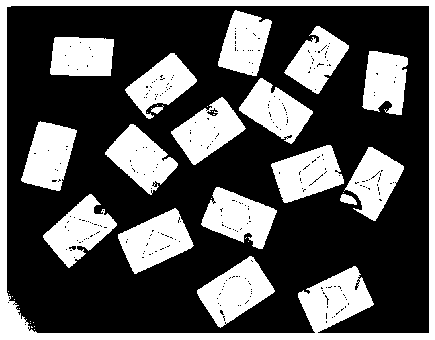

In [17]:
thrsh = 120

plot_image((img_grey < thrsh) * 256)

Конечно же, существуют автоматические методы выбора порога биаризации, например: [метод K-средних](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [метод Отцу](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%9E%D1%86%D1%83) и др.

В некоторых случаях изображение может быть не таким хорошим: значения яркостей пикселей могут быть сосредоточены в одной области. В этих случаях применяют, так называемую, [эквализацию гистограмм](https://en.wikipedia.org/wiki/Histogram_equalization).

То же самое можно сделать с помощью бибилиотеки `opencv`.

In [18]:
thrsh1, img_mask1 = cv2.threshold(img_grey, thrsh, 255, cv2.THRESH_BINARY_INV)
img_mask2 = cv2.adaptiveThreshold(img_grey, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 5)

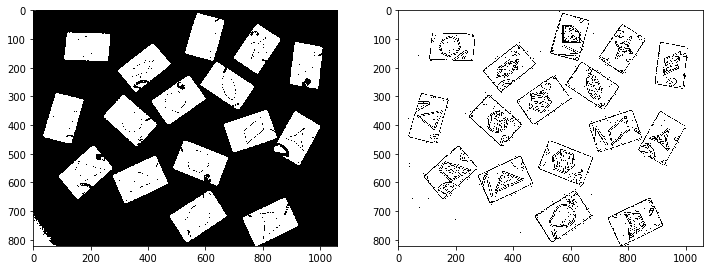

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].imshow(img_mask1, cmap='gray')
ax[1].imshow(img_mask2, cmap='gray')

Остановимся на первом варианте.

In [20]:
img_mask = img_mask1

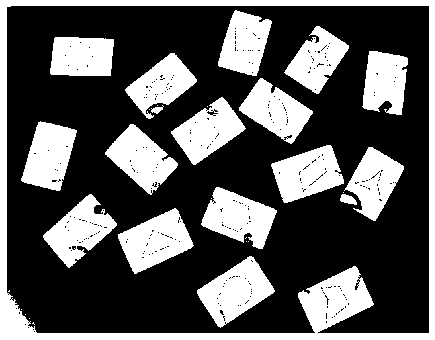

In [21]:
plot_image(img_mask)

<span style="color:blue;font-weight:bold">Задача.</span> Как еще можно улучшить качество бинаризации? Какое главное отличие карточек от фона?

Видим, что нам достаточно хорошо удалось отделить карточки от фона за исключением "дырок" вутри карточек и засвета справа в углу. Попробуем удалить "дырки" внутри карточек.

Рассмотрим методы сглаживания изображения с использовнием фильтров.

<img src="data/MedianFiltering.png" class="flipthis-highlight">

Примеры нелинейных фильтров:

* `median-фильтр` - медианный фильтр;
* `min/max-фильтр` - замена значения на `min/max`.

Примеры линейных фильтров:

* `mean-фильтр` - среднеарифметический фильтр;
* гауссовский фильтр (gaussian-blur):

$$Y[i, j] = \sum_{l = -k}^k \sum_{m = -k}^k X[i + l, j + m] \frac{1}{\sqrt{2 \pi \sigma}} \exp\left(-\frac{\sqrt{l^2 + m^2}}{2\sigma^2}\right)$$

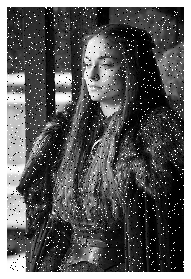

In [22]:
img_example = cv2.imread('data/stark.jpg', 0)
img_example_bak = img_example.copy()

index = np.random.choice(img_example.size, replace=False, size=int(0.035 * img_example.size))
img_example.ravel()[index] = 0

index = np.random.choice(img_example.size, replace=False, size=int(0.035 * img_example.size))
img_example.ravel()[index] = 255

plot_image(img_example, zoom=0.75)

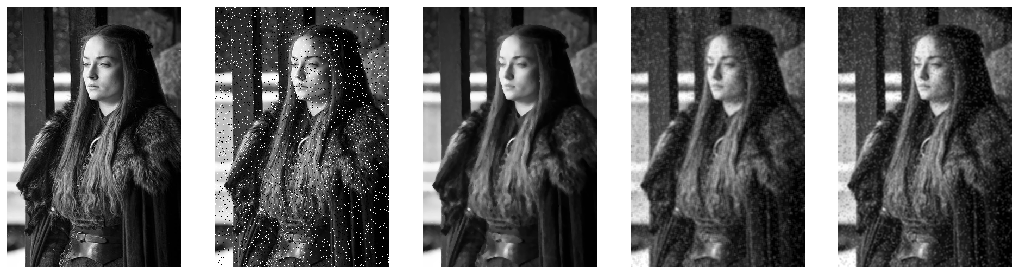

In [23]:
images = [
    img_example_bak, # исходное изображение
    img_example,     # исходное изображение с зашумлением
    cv2.medianBlur(img_example, 5),   # медианный фильтр
    cv2.filter2D(img_example, -1, np.ones((5, 5)) / 25.0),      # среднеарифметический фильтр
    cv2.GaussianBlur(img_example, ksize=(5, 5), sigmaX=1.5,),   # гаусовский фильтр
]

fig, axes = plt.subplots(1, len(images), figsize=(18, 8))

for img_, ax_ in zip(images, axes):
    ax_.imshow(img_, cmap='gray')
    ax_.axis('off')
plt.show()

Среднеарифметический фильтр можно рассматривать, как свертку. Сверткой $A * B$ будем называть:

$$ (A * B)(x, y) = \sum_i \sum_j A(i, j) B(x - i, y - j) $$

где $B$ - исходное изображение, а $A$ - свертка.

<span style="color:red;font-weight:bold">Внмание:</span> обратите внимание на знаки индексов в матрице B. Они означают, что свертку A нужно отражать по вертикали и горизонтали. В примере ниже свертка УЖЕ развернута.

<img src="data/art4_one_conv.png" class="flipthis-highlight" width="600px">

Среди полезных сверток стоит выделить [оператор Собеля](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80_%D0%A1%D0%BE%D0%B1%D0%B5%D0%BB%D1%8F), который используется для выделения границ.

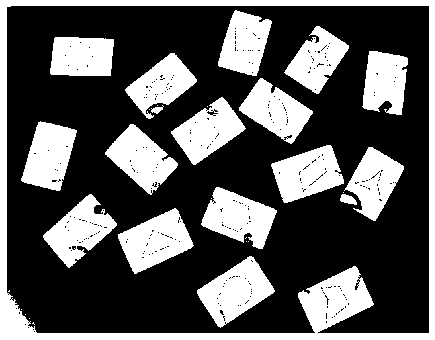

In [24]:
plot_image(img_mask)

Вернемся к исходной задаче.

<span style="color:blue;font-weight:bold">Вопрос:</span> какой из фильтров лучше всего подойдет для задачи удаления "дырок" внутри карточек?

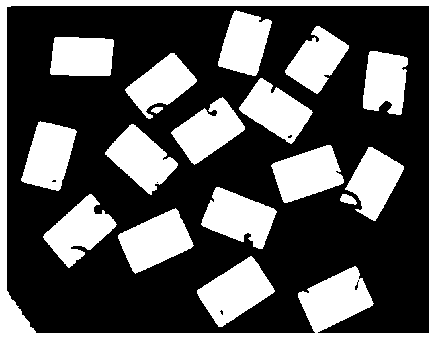

In [25]:
plot_image(cv2.medianBlur(img_mask, 7))

Для устранения разрывов в изображении используется преобразование [дилатации](https://ru.bmstu.wiki/%D0%94%D0%B8%D0%BB%D0%B0%D1%82%D0%B0%D1%86%D0%B8%D1%8F_(%D0%9C%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BC%D0%BE%D1%80%D1%84%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D1%8F)). Для удаления деталей – [эрозия](https://ru.bmstu.wiki/%D0%AD%D1%80%D0%BE%D0%B7%D0%B8%D1%8F_(%D0%9C%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BC%D0%BE%D1%80%D1%84%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D1%8F)).

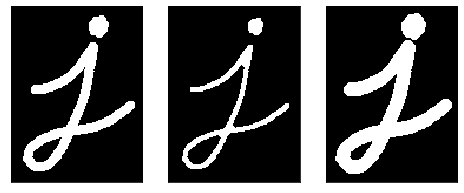

In [26]:
from skimage.morphology import disk

img_example = 255 - cv2.imread('data/morphology.png', 0)
images = [ 
    img_example,
    cv2.erode(img_example, disk(2)),
    cv2.dilate(img_example, disk(2))
]

fig, axes = plt.subplots(1, len(images), figsize=(8, 4))

for img_, ax_ in zip(images, axes):
    ax_.imshow(img_, cmap='gray')
    ax_.set_xticks([])
    ax_.set_yticks([])
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

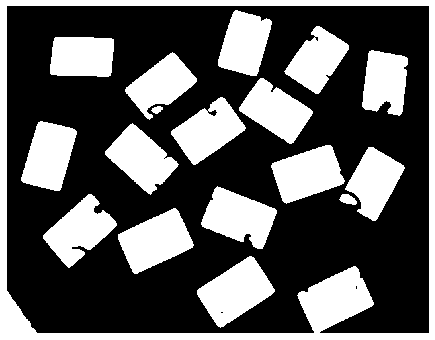

In [27]:
img_mask = cv2.medianBlur(img_mask, 7)
img_mask = cv2.erode(img_mask, disk(3))
img_mask = cv2.dilate(img_mask, disk(4))
img_mask = cv2.medianBlur(img_mask, 7)

plot_image(img_mask)

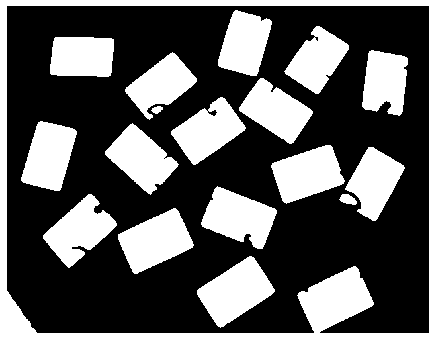

In [28]:
def remove_holes(img):
    # эмпирический способ удаления "дырок"
    
    img_flood_fill = img.copy()
    
    h, w = img_flood_fill.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)
    
    cv2.floodFill(img_flood_fill, mask, (0, 0), 255)
    img_flood_fill = cv2.bitwise_not(img_flood_fill)
    
    return img | img_flood_fill

img_mask = remove_holes(img_mask)
plot_image(img_mask)

Что можно еще сделать?

* аппроксимировать выделенные области четырехугольниками.

## Задача 2. Геометрические преобразования

Как мы уже обсуждали до это этого, в некоторых случаях аугментация данных может привести к улучшению обобщающей способности вашего алгоритма. Рассмотрим некоторые геометрические преобразование на примере библиотеки `skimage`.

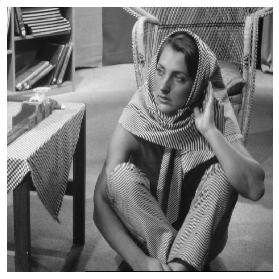

(512, 512)

In [29]:
img = cv2.imread('data/barbara.jpg', 0)
plot_image(img, zoom=0.75)
img.shape

В библиотеке `skimage` есть поддержка поворотов изображения. При этом можно выбрать, хотим ли мы чтобы изображение было прежнего размера, или нет.

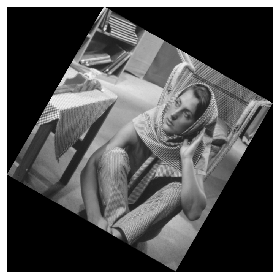

(700, 700)

In [30]:
from skimage import transform

img_ = transform.rotate(img, -30, resize=True)
plot_image(img_, zoom=0.75)
img_.shape

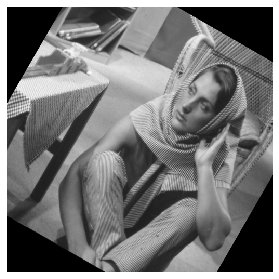

(512, 512)

In [31]:
img_ = transform.rotate(img, -30)
plot_image(img_, zoom=0.75)
img_.shape

<span style="color:blue;font-weight:bold">Задача.</span> С помощью библиотеки `numpy` выполните следующие пункты:
* зеркально отразите изображение `img` относительно горизонтали;
* поверните изображение `img` на 90˚ влево;
* поверните изображение `img` на 90˚ вправо.

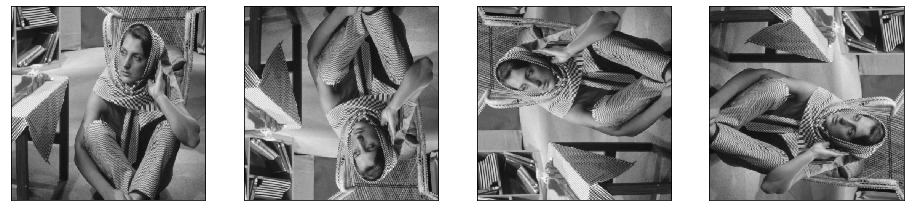

In [32]:
images = [
    img,
    img[::-1, :],
    img[:, ::-1].T,
    img[::-1, :].T
]

fig, axes = plt.subplots(1, len(images), figsize=(16, 6))

for img_, ax_ in zip(images, axes):
    ax_.imshow(img_, cmap='gray')
    ax_.set_xticks([])
    ax_.set_yticks([])
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

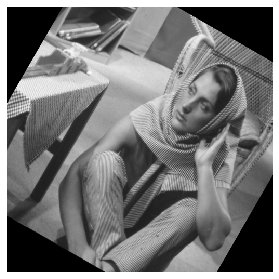

In [33]:
img = transform.rotate(img, -30)
plot_image(img, zoom=0.75)

Для того, чтобы обрезать изображение, воспользуемся функцией `crop`.

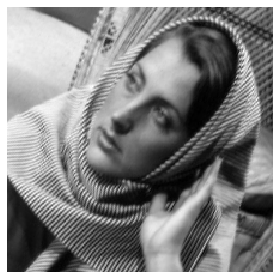

(222, 222)

In [34]:
from skimage.util import crop

img_ = crop(img, [(100, 190), (250, 40)])
plot_image(img_, zoom=0.75)
img_.shape

В таком случае изображение уменьшилось до размеров `222x222` пикселей. Применим преобразование масштаба для того, чтобы вернуть его к исходному изображению.

/Users/v.bugaevskii/miniconda3/envs/ml-py37/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


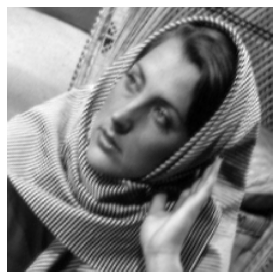

(512, 512)

In [35]:
img_ = transform.rescale(img_, 2.306)
plot_image(img_, zoom=0.75)
img_.shape

In [36]:
img = img_

Библиотека `skimage` не имеет "из коробки" преобразования сдвига. Зато она есть в `scipy`.

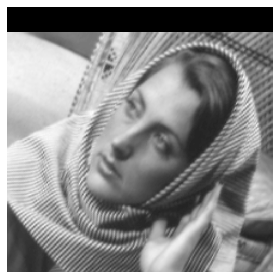

In [37]:
import scipy.ndimage as ndimage

plot_image(ndimage.shift(img, [50, 0]), zoom=0.75)

## Подготовка к домашнему заданию

In [38]:
def plot_mnist(images, N, M):
    f, axarr = plt.subplots(N, M, figsize=(8, 8))
    k = 0
    for i in range(N):
        for j in range(M):
            axarr[i, j].imshow(images[k], cmap='gray_r')
            # axarr[i, j].set_title(labels[m * i + j])
            axarr[i, j].tick_params(
                axis='both', which='both',
                bottom='off', top='off', right='off', left='off',
                labelbottom='off', labelleft='off', length=0
            )
            axarr[i, j].set_xticks([])
            axarr[i, j].set_yticks([])
            # axarr[i, j].axis('off')
            k += 1
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

[`MNIST`](http://yann.lecun.com/exdb/mnist/) – датасет из рукописных цифр. Датасет состоит из изображений размером `28х28`, каждый пиксель которого представляет собой оттенок серого.

In [39]:
from data.MNIST.data_extraction import read_image_file, read_label_file, LABELS_TRAIN, IMAGES_TRAIN

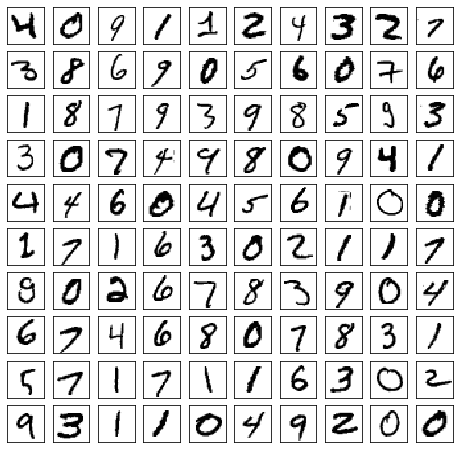

array([[4, 0, 9, 1, 1, 2, 4, 3, 2, 7],
       [3, 8, 6, 9, 0, 5, 6, 0, 7, 6],
       [1, 8, 7, 9, 3, 9, 8, 5, 9, 3],
       [3, 0, 7, 4, 9, 8, 0, 9, 4, 1],
       [4, 4, 6, 0, 4, 5, 6, 1, 0, 0],
       [1, 7, 1, 6, 3, 0, 2, 1, 1, 7],
       [9, 0, 2, 6, 7, 8, 3, 9, 0, 4],
       [6, 7, 4, 6, 8, 0, 7, 8, 3, 1],
       [5, 7, 1, 7, 1, 1, 6, 3, 0, 2],
       [9, 3, 1, 1, 0, 4, 9, 2, 0, 0]], dtype=uint8)

In [40]:
batch_size, offset = 100, 20

labels = read_label_file(LABELS_TRAIN, batch_size, offset)
images = read_image_file(IMAGES_TRAIN, batch_size, offset)

N, M = 10, 10
plot_mnist(images, N, M)

labels.reshape((N, M))

In [41]:
images[0].shape

(28, 28)

Датасет `MNIST` является классическим, поэтому не нужно писать свой код (как в примере выше) для импортирования данных. Достаточно заглянуть в `sklearn`.

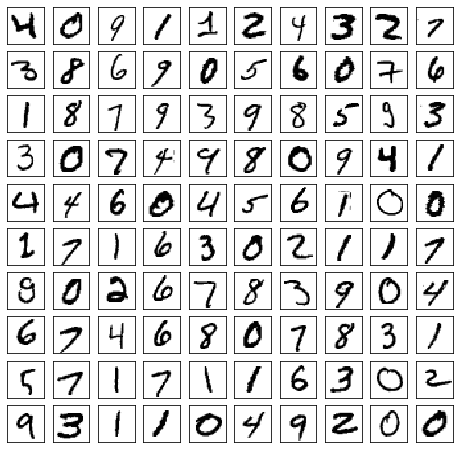

array([['4', '0', '9', '1', '1', '2', '4', '3', '2', '7'],
       ['3', '8', '6', '9', '0', '5', '6', '0', '7', '6'],
       ['1', '8', '7', '9', '3', '9', '8', '5', '9', '3'],
       ['3', '0', '7', '4', '9', '8', '0', '9', '4', '1'],
       ['4', '4', '6', '0', '4', '5', '6', '1', '0', '0'],
       ['1', '7', '1', '6', '3', '0', '2', '1', '1', '7'],
       ['9', '0', '2', '6', '7', '8', '3', '9', '0', '4'],
       ['6', '7', '4', '6', '8', '0', '7', '8', '3', '1'],
       ['5', '7', '1', '7', '1', '1', '6', '3', '0', '2'],
       ['9', '3', '1', '1', '0', '4', '9', '2', '0', '0']], dtype=object)

In [42]:
from sklearn import datasets

images, labels = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
images = images.reshape(-1, 28, 28)

images = images[offset:offset + N * M]
labels = labels[offset:offset + N * M]

plot_mnist(images, N, M)

labels.reshape((N, M))

In [43]:
images[0].shape

(28, 28)

`MNIST` – не единственный датасет с цифрами. См. например, `sklearn.datasets.load_digits`.